# Group 33 Project: Prediction of Diabetes Diagnosis #

Group members: Billie Beis-Leech, Anna Daoust, Fintan Casey, and Yash Mali

# Introduction

Diabetes is a health condition that affects how our bodies process nutrients into energy. Characterized by a deficiency of insulin, diabetes results in an abnormally high amount of glucose in the bloodstream. This can cause serious health problems, and so it is beneficial to predict in early stages.

Our study will answer the following predictive question: What is the diabetes status of a patient, given their medical profile? The Diabetes Prediction Dataset will be used to answer this question, containing medical and demographical data such as age, gender, body mass index (BMI), hypertension, heart disease, smoking history, HbA1c level, and blood glucose level. Diabetes status is labeled with a 1 indicating the presence of diabetes, and a 0 indicating the absence. These findings can be used to analyze the functionality of these predictors, further developing our predictive models for diabetes status.

# Methods

The Diabetes Prediction Dataset was loaded into a Jupyter notebook using the original URL from the Kaggle website into a data frame format. The rows containing ‘No Info’ for the Smoking History column and ‘Other’ for the Gender column were removed, and any observation with an age valuing under 2 was also removed. In addition, diabetes status labeled with either a 0 or a 1 was mutated to be a factor variable.


To perform summary statistics, the data frame was split into two parts. 75% of the data was labeled as the training set, and 25% of the data was labeled as the testing set. Using the training set, the data was grouped into presence or absence of diabetes, and the number of observations and percentage was summarized for both of these categories (Table 1). The final table summarizes statistics for each of the four predictor variables: age, BMI, HbA1c level, and blood glucose level. The mean, minimum, and maximum value for each predictor variable was calculated and presented (Table 2).


A subset of 2500 observations from the total data set were utilized for exploratory visualizations. Each visualization depicts BMI with a second predictor variable, and the relationship between them in the form of a scatter plot, creating three total graphs (Figure 1).  Each scatter plot is coloured to represent diabetes status, with orange showing absence of diabetes, and purple showing presence of diabetes. 


To find the optimal k value for the data analysis, variables were first scaled in a recipe. To tune the model, k values 1 to 10 were specified and combined into a workflow. Cross validation with 5 folds was used in the classification model to calculate the accuracies for each k value in the range of 1 to 10, and these accuracies were plotted as a continuous line in order to visualize the number of neighbors with the most optimal accuracy (Figure 2). The model was then re-trained with the most optimal k value, 3, using the training data set.


Following the training of the model, the testing set was used to evaluate the accuracy of the classifier, and these results were used to generate a confusion matrix that presents how many cases were correctly identified as diabetic or non-diabetic.


## Reading and wrangling the data

In [1]:
# loading the libraries
library(tidyverse)
library(tidymodels)
library(gridExtra)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
# setting the seed
set.seed(1)

# loading the data
url <- "https://raw.githubusercontent.com/billiehbl/project_group33/main/diabetes_prediction_dataset.csv"
diabetes_data <- read_csv(url)

# tidying the data
tidy_diabetes <- diabetes_data |> filter(smoking_history != "No Info") |> filter(gender != 'Other')|>
    filter(age >= 2)|> mutate(diabetes = as_factor(diabetes))
head(tidy_diabetes)
dim(tidy_diabetes)

Rows: 100000 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): gender, smoking_history
dbl (7): age, hypertension, heart_disease, bmi, HbA1c_level, blood_glucose_l...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
Female,80,0,1,never,25.19,6.6,140,0
Male,28,0,0,never,27.32,5.7,158,0
Female,36,0,0,current,23.45,5.0,155,0
Male,76,1,1,current,20.14,4.8,155,0
Female,20,0,0,never,27.32,6.6,85,0
Female,44,0,0,never,19.31,6.5,200,1


[1] 64012     9

## Splitting into testing and training data sets

In [3]:
# creating the training / testing split
diabetes_split <- initial_split(tidy_diabetes, prop = 0.60, strata = diabetes)
diabetes_train <- training(diabetes_split)
diabetes_train = diabetes_train[sample(1:nrow(diabetes_train)), ] # shuffles data frame
diabetes_test <- testing(diabetes_split)

## Summary statistics

*Calculating the number and percentage of observations in each category*

In [4]:
nrow_diabetes <- nrow(diabetes_train)
training_counts <- diabetes_train |> group_by(diabetes) |>
    summarize(count = n(), percentage = n() / nrow_diabetes)
training_counts

diabetes,count,percentage
<fct>,<int>,<dbl>
0,34179,0.8899391
1,4227,0.1100609


Table 1. ...

*Calculating summary statistics for predictor variables*

In [5]:
# calculating means for each predictor variable
means <- diabetes_train |>
        summarize(age = mean(age), bmi = mean(bmi),
        HbA1c = mean(HbA1c_level), blood_glucose = mean(blood_glucose_level))
tidy_means <- pivot_longer(means, cols = age:blood_glucose,
        names_to = "factor", values_to = "mean")

# calculating minimum values for each predictor variable
mins <- diabetes_train |>
        summarize(age = min(age), bmi = min(bmi),
        HbA1c = min(HbA1c_level), blood_glucose = min(blood_glucose_level))
tidy_mins <- pivot_longer(mins, cols = age:blood_glucose,
        names_to = "factor", values_to = "minimum")

# calculating maximum values for each predictor variable
maximum <- diabetes_train |>
        summarize(age = max(age), bmi = max(bmi),
        HbA1c = max(HbA1c_level), blood_glucose = max(blood_glucose_level))
tidy_max <- pivot_longer(maximum, cols = age:blood_glucose,
        names_to = "factor", values_to = "maximum")

# creating final summary table
summary <- tidy_means |>
        bind_cols(tidy_mins |> select(minimum)) |>
        bind_cols(tidy_max |> select(maximum))
summary

factor,mean,minimum,maximum
<chr>,<dbl>,<dbl>,<dbl>
age,46.520986,2.00,80.00
bmi,28.461086,10.08,88.76
HbA1c,5.570611,3.50,9.00
blood_glucose,139.762902,80.00,300.00


Table 2. ...

## Exploratory visualizations

*Creating a smaller sample from the data*

In [6]:
diabetes_sample <- diabetes_train |> sample_n(2500)

*Making the visualizations*

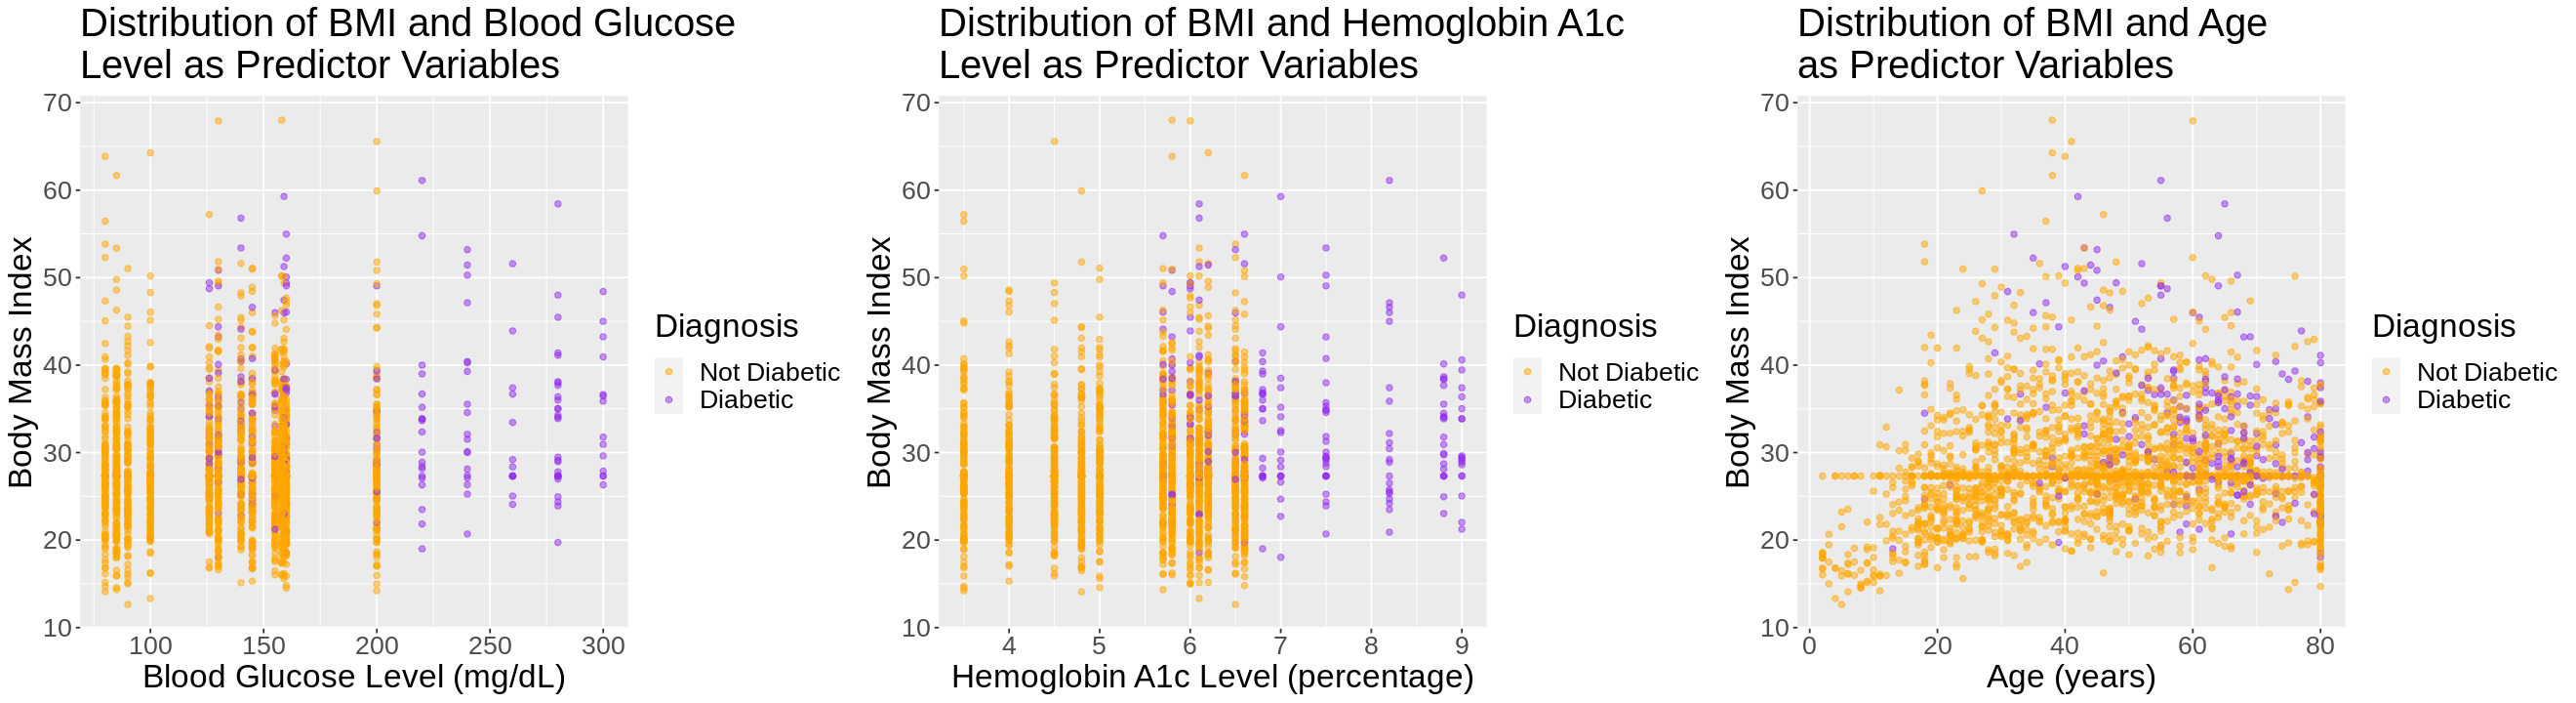

In [7]:
options(repr.plot.width = 22, repr.plot.height = 6)

# creating graph of the distribution of BMI and blood glucose predictors
bmi_blood_glucose <- diabetes_sample |>
    ggplot(aes(x = blood_glucose_level, y = bmi, color = diabetes)) +
    geom_point(alpha = 0.5) +
    labs(x = "Blood Glucose Level (mg/dL)", y = "Body Mass Index", color = "Diagnosis") +
    ggtitle("Distribution of BMI and Blood Glucose \nLevel as Predictor Variables") +
    scale_color_manual(labels = c("Not Diabetic", "Diabetic"),
    values = c("orange", "purple2")) +
    theme(text = element_text(size = 20))

# creating graph of the distribution of BMI and hemoglobin A1c predictors
bmi_HbA1c <- diabetes_sample |>
    ggplot(aes(x = HbA1c_level, y = bmi, color = diabetes)) +
    geom_point(alpha = 0.5) +
    labs(x = "Hemoglobin A1c Level (percentage)", y = "Body Mass Index", color = "Diagnosis") +
    ggtitle("Distribution of BMI and Hemoglobin A1c \nLevel as Predictor Variables") +
    scale_color_manual(labels = c("Not Diabetic", "Diabetic"),
    values = c("orange", "purple2")) +
    theme(text = element_text(size = 20))

# creating graph of the distribution of BMI and age predictors
bmi_age <- diabetes_sample |>
    ggplot(aes(x = age, y = bmi, color = diabetes)) +
    geom_point(alpha = 0.5) +
    labs(x = "Age (years)", y = "Body Mass Index", color = "Diagnosis") +
    ggtitle("Distribution of BMI and Age \nas Predictor Variables") +
    scale_color_manual(labels = c("Not Diabetic", "Diabetic"),
    values = c("orange", "purple2")) +
    theme(text = element_text(size = 20))

plot_grid(bmi_blood_glucose, bmi_HbA1c, bmi_age,
          ncol = 3)

Figure 1. ...

# Results

## Data analysis

*Tuning the model*

In [8]:
# creating recipe and scaling predictors
diabetes_recipe <- recipe(diabetes ~ bmi + HbA1c_level + blood_glucose_level + age,
                          data = diabetes_sample) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

# specifying k values for tuning
kvals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

# creating tuning specifications
diabetes_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

# creating folds for cross-validation
diabetes_vfold <- vfold_cv(diabetes_sample, v = 5, strata = diabetes)

# calculating accuracies for each k value
diabetes_accuracies <- workflow() |>
        add_recipe(diabetes_recipe) |>
        add_model(diabetes_tune) |>
        tune_grid(resamples = diabetes_vfold, grid = kvals) |>
        collect_metrics() |>
        filter(.metric == "accuracy")
diabetes_accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9440,5,0.004774935,Preprocessor1_Model01
2,accuracy,binary,0.9440,5,0.004774935,Preprocessor1_Model02
3,accuracy,binary,0.9556,5,0.002638181,Preprocessor1_Model03
4,accuracy,binary,0.9556,5,0.002638181,Preprocessor1_Model04
5,accuracy,binary,0.9580,5,0.003346640,Preprocessor1_Model05
6,accuracy,binary,0.9580,5,0.003346640,Preprocessor1_Model06
7,accuracy,binary,0.9560,5,0.003577709,Preprocessor1_Model07
8,accuracy,binary,0.9560,5,0.003577709,Preprocessor1_Model08
9,accuracy,binary,0.9560,5,0.002607681,Preprocessor1_Model09


Table 3. ...

*Plotting the accuracies*

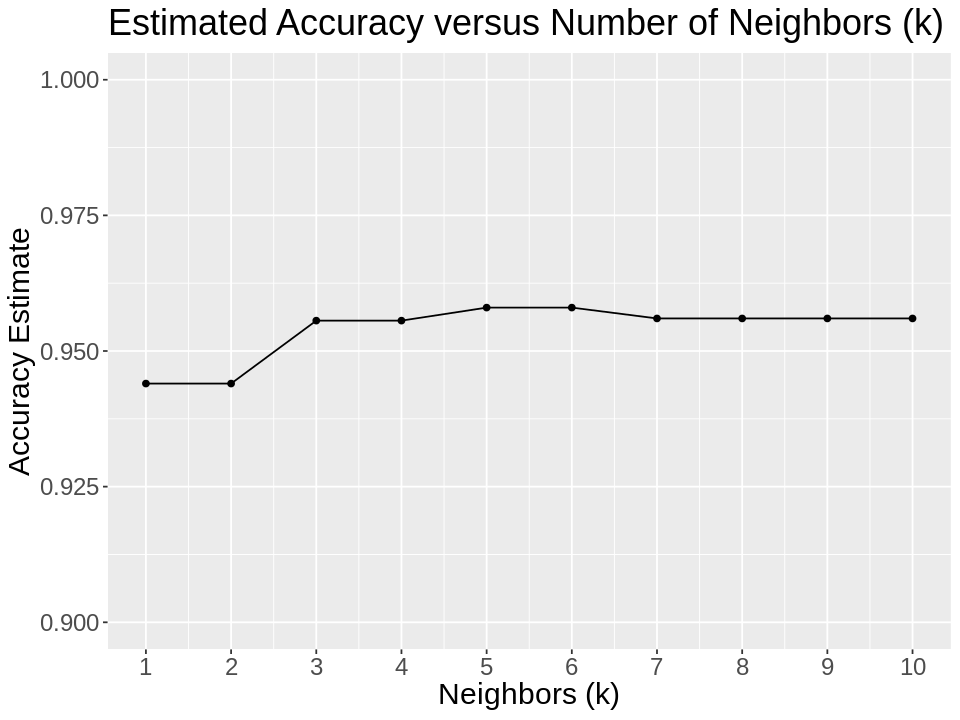

In [9]:
options(repr.plot.width = 8, repr.plot.height = 6)

accuracy_versus_k <- ggplot(diabetes_accuracies, aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "Neighbors (k)", y = "Accuracy Estimate") +
        scale_x_continuous(breaks = seq(0, 25, by = 1)) +  
        scale_y_continuous(limits = c(0.9, 1.0)) +
        theme(text = element_text(size = 18)) +         
        ggtitle("Estimated Accuracy versus Number of Neighbors (k)")
accuracy_versus_k

Figure 2. ...

*Re-training the model*

In [10]:
diabetes_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification") 

diabetes_fit <- workflow() |>
    add_recipe(diabetes_recipe) |>
    add_model(diabetes_spec) |>
    fit(data = diabetes_train)

*Evaluating the classifier's accuracy on the testing set*

In [11]:
diabetes_predictions <- predict(diabetes_fit, diabetes_test) |>
    bind_cols(diabetes_test)
head(diabetes_predictions)
dim(diabetes_predictions)
diabetes_metrics <- diabetes_predictions |>
    metrics(truth = diabetes, estimate = .pred_class) |>
    filter(.metric == "accuracy")

.pred_class,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
0,Female,36,0,0,current,23.45,5.0,155,0
0,Female,20,0,0,never,27.32,6.6,85,0
0,Male,42,0,0,never,33.64,4.8,145,0
0,Female,54,0,0,former,54.70,6.0,100,0
0,Female,67,0,0,never,25.69,5.8,200,0
0,Male,37,0,0,ever,25.72,3.5,159,0


[1] 25606    10

Table 4. ...

*Generating the confusion matrix*

In [12]:
diabetes_conf_mat <- diabetes_predictions |>
    conf_mat(truth = diabetes, estimate = .pred_class)
diabetes_conf_mat

          Truth
Prediction     0     1
         0 22480   912
         1   307  1907

Table 5. ...

## Visualization of results

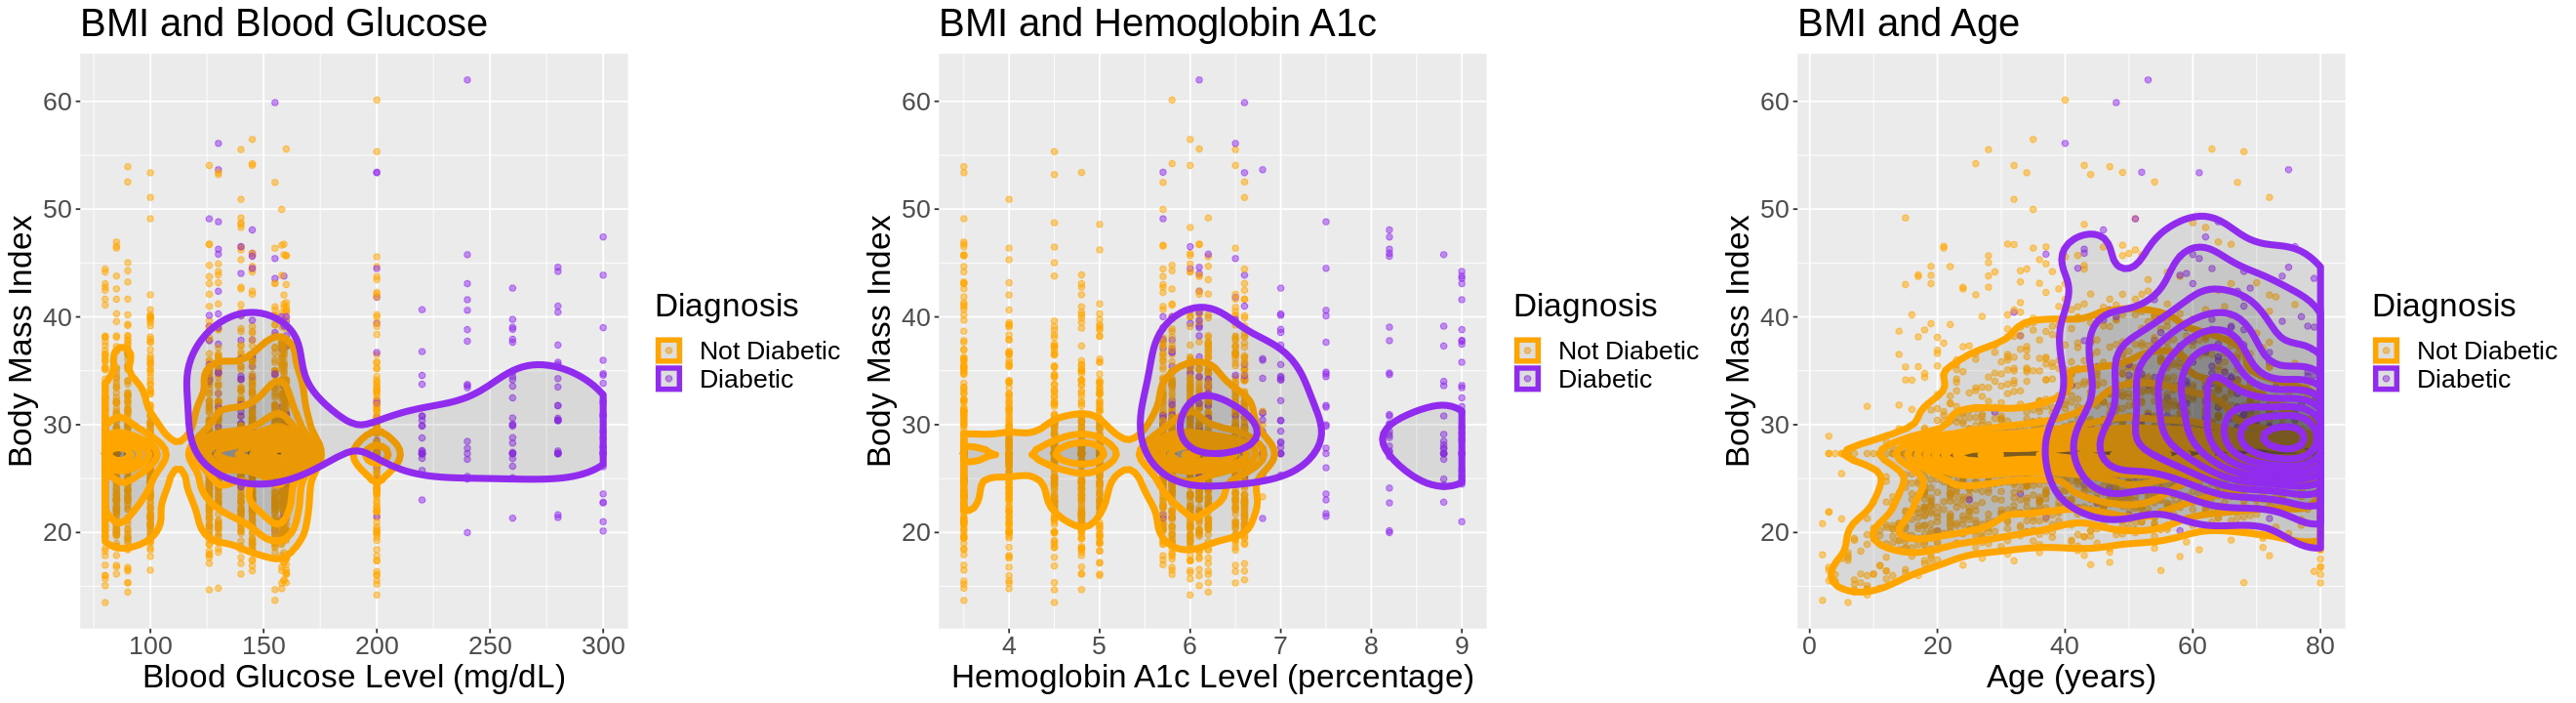

In [14]:
options(repr.plot.width = 22, repr.plot.height = 6)

diabetes_sample_train <- diabetes_predictions |>
    sample_n(2500)

# creating graph of the distribution of BMI and blood glucose predictors
bmi_blood_glucose <- diabetes_sample_train |>
    ggplot(aes(x = blood_glucose_level, y = bmi, color = .pred_class, alpha = 0.1)) +
    geom_point(alpha = 0.5) +
    labs(x = "Blood Glucose Level (mg/dL)", y = "Body Mass Index", color = "Diagnosis") +
    ggtitle("BMI and Blood Glucose") +
    scale_color_manual(labels = c("Not Diabetic", "Diabetic"),
    values = c("orange", "purple2")) +
    theme(text = element_text(size = 20))  + 
    stat_density_2d(geom="polygon", alpha = 0.1, size = 2)

# creating graph of the distribution of BMI and hemoglobin A1c predictors
bmi_HbA1c <- diabetes_sample_train |>
    ggplot(aes(x = HbA1c_level, y = bmi, color = .pred_class, alpha = 0.1)) +
    geom_point(alpha = 0.5) +
    labs(x = "Hemoglobin A1c Level (percentage)", y = "Body Mass Index", color = "Diagnosis") +
    ggtitle("BMI and Hemoglobin A1c") +
    scale_color_manual(labels = c("Not Diabetic", "Diabetic"),
    values = c("orange", "purple2")) +
    theme(text = element_text(size = 20)) + 
    stat_density_2d(geom="polygon", alpha = 0.1, size = 2)

# creating graph of the distribution of BMI and age predictors
bmi_age <- diabetes_sample_train |>
    ggplot(aes(x = age, y = bmi, color = .pred_class, alpha = 0.01)) +
    geom_point(alpha = 0.5) +
    labs(x = "Age (years)", y = "Body Mass Index", color = "Diagnosis") +
    ggtitle("BMI and Age") +
    scale_color_manual(labels = c("Not Diabetic", "Diabetic"),
    values = c("orange", "purple2")) +
    theme(text = element_text(size = 20)) + 
    stat_density_2d(geom="polygon", alpha = 0.1, size = 2)

plot_grid(bmi_blood_glucose, bmi_HbA1c, bmi_age, ncol = 3)


# Discussion

The results show that high values of age, BMI, blood glucose and hemoglobin A1c are generally correlated with being diagnosed with Diabetes Mellitus. 
	In the “Distribution of BMI and Age as Predictor Variables” graph, we see that the highest BMI value has a diabetic label and that the majority of diabetic labels have a value above a BMI of 30. Moreover, this graph also shows that the majority of points with the diabetic label are after the age of 40, indicating that the older one is, the more likely they are to contract diabetes.
	In the “Distribution of BMI and Hemoglobin A1c Level as Predictor Variables” graph, it is evident that the majority of values with the diabetic label are valued between 6 to 9 for the Hemoglobin A1c level, compared to the not-diabetic label valued between 3.5 to 6.5. This implies that the higher one’s Hemoglobin A1c level, the more likely they are to be diagnosed with diabetes. Moreover, the highest value of BMI is associated with a diabetic label and, on average, the BMI values associated with the diabetic label are higher than those with a not-diabetic label.
	Lastly, in the “Distribution of BMI and Blood Glucose Level as Predictor Variables” graph, it is apparent that the highest levels of blood glucose are associated with the diabetic label. Furthermore, on average, the BMI associated with the diabetic label has points that are higher in value than that of the not-diabetic labels.
    

These are in fact results that we expected to find. As mentioned in the proposal, we stated that the individuals who score the highest in the predictor variables will be more likely to have diabetes compared to those who scored lower in these categories. It is quite well known that obesity has a very strong positive relationship with diabetes. For example, a large scale study conducted by Hartz et al. in 1983 measured the waist-to-hip girth ratio of around 15,500 women. The study’s results showed that “the prevalence of diabetes increased with increasing values of this ratio” and that women who were ranked in the upper 25% were three times more likely to have diabetes compared to women who were ranked in the lower 25%. Lastly, Hartz found that women who had serious obesity “had a relative risk of diabetes 10.3 times as great as nonobese subjects” (Hartz et al., 1983).


After finding that those who are older and have higher BMIs, blood glucose and hemoglobin A1c levels,  we can work towards developing predictive/early detection models and risk assessment tools to identify the individuals who are at high risk for diabetes. In this way, these findings can help healthcare professionals initiate prevention strategies and provide interventions to improve patient outcomes. As a result of this, the prevalence of diabetes would not present as much of a burden on healthcare systems because it would pose less strain on diagnostics, infrastructure, and disease management.
	And lastly, these findings could have a significant impact on the importance of public health interventions to address the underlying causes of high BMI and blood glucose levels. Interventions could include campaigns to promote healthy lifestyles such as hypocaloric diets combined with education and low-impact exercise. Another intervention could result in policies being enforced that improve access to nutritious food.


These results can lead to many possible future questions. An important question to consider is how our specific variables (Body Mass Index, blood glucose, and Hemoglobin A1c level) interact with factors such as socioeconomic status to influence the risk of contracting diabetes. For example, a study conducted by Brancati et al. found that participants who were overweight and had more fatty tissue, “had lower socioeconomic status.” Moreover, Brancati highlights that the prevalence of diabetes “was greatest in individuals of low socioeconomic status” and “least among individuals of high socioeconomic status.” We can go further than this and question if genetic predispositions or other lifestyle factors can also increase the susceptibility of being diagnosed with diabetes (Brancati et al., 1996).

# References

Brancati, F. L., Whelton, P. K., Kuller, L. H., & Klag, M. J. (1996c). Diabetes mellitus, race, and socioeconomic status a population-based study. Annals of Epidemiology, 6(1), 67–73. https://doi.org/10.1016/1047-2797(95)00095-x

Hartz, A. J., Rupley, D. C., Kalkhoff, R. K., & Rimm, A. A. (1983). Relationship of obesity to diabetes: Influence of obesity level and body fat distribution,. Preventive Medicine, 12(2), 351–357. https://doi.org/10.1016/0091-7435(83)90244-x

Mohammed Mustafa. 2023. "Diabetes prediction dataset: A Comprehensive Dataset for Predicting Diabetes with Medical & Demographic Data", Version 1.